### DCGAN with Cat-Face dataset

- 아래 자료들을 참고했습니다.
    - https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5
    - https://github.com/shubham7169/Projects/blob/master/CAT-dcgan.ipynb

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

### Practice
- Load cat dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)])

# TODO
train_ds = ImageFolder('./data/', transform=transform)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [5]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

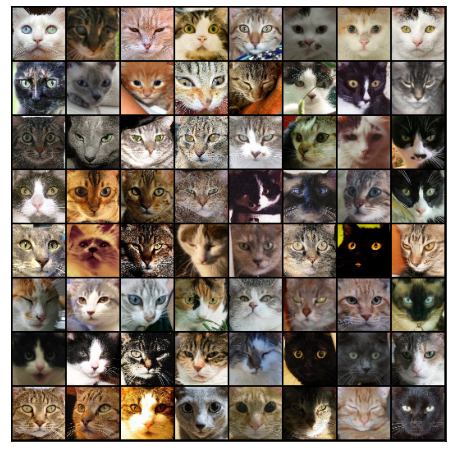

In [6]:
for images, _ in train_dl:
    show_images(images, 64)
    break

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

### Define Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
        
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        
        
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        
        
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        
        
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        
        
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        
        nn.Flatten(),
        nn.Sigmoid())
        
    def forward(self, x):
        x = self.model(x)
        return x    

discriminator = Discriminator()
discriminator = to_device(discriminator, device)

### Define Generator

In [11]:
latent_size = 128

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            
        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh())
        
    def forward(self, x):
        x = self.model(x)
        return x  
    
generator = Generator(latent_size)

### Initial Generator Results

torch.Size([128, 3, 64, 64])


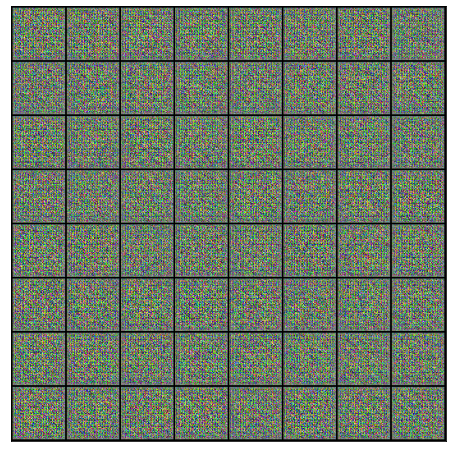

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [13]:
generator = to_device(generator, device)

### Practice
- Implement discriminator loss


$$ \mathcal{L}_{D} = \mathbb{E}_{z \sim N(0,I), x \sim p_{data}(x)}[log(D(x)) + log(1 - D(G(z)))] $$
$$  $$
$$ or $$
$$ \mathcal{L}_{D} = \frac{1}{N}\sum_{i}^{N}[log(D(x_{i})) + log(1 - D(G(z_{i})))] $$

In [14]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Practice
- Implement generator loss

$$ \mathcal{L}_{G} = \mathbb{E}_{z \sim N(0,I)}[log(1 - D(G(z)))] $$
$$  $$
$$ or $$
$$ \mathcal{L}_{G} = \frac{1}{N} \sum_{i}^{N}[log(1 - D(G(z_{i})))] $$

In [15]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [16]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [17]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [18]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


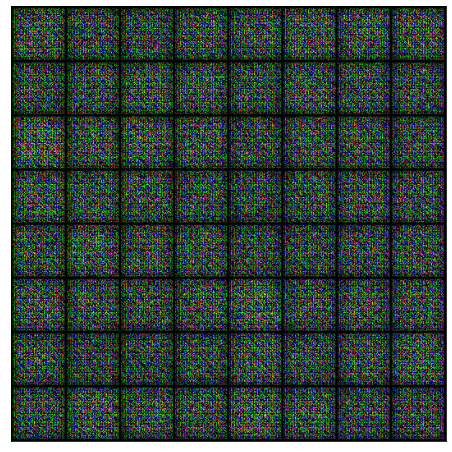

In [19]:
save_samples(0, fixed_latent)

In [20]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [21]:
lr = 0.0002
epochs = 60

In [22]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 2.9924, loss_d: 0.3467, real_score: 0.8235, fake_score: 0.1025
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 1.2583, loss_d: 0.7956, real_score: 0.6085, fake_score: 0.1865
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 2.8660, loss_d: 0.4831, real_score: 0.8296, fake_score: 0.2445
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 2.7386, loss_d: 0.6894, real_score: 0.7211, fake_score: 0.2206
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 6.3386, loss_d: 1.1287, real_score: 0.8900, fake_score: 0.5875
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 6.9141, loss_d: 0.7987, real_score: 0.9644, fake_score: 0.4595
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 4.5757, loss_d: 0.9363, real_score: 0.6961, fake_score: 0.3593
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 3.2668, loss_d: 0.4652, real_score: 0.7040, fake_score: 0.0867
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 3.3749, loss_d: 0.8078, real_score: 0.6220, fake_score: 0.2004
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 3.2714, loss_d: 0.2407, real_score: 0.8519, fake_score: 0.0710
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.5694, loss_d: 0.2546, real_score: 0.9774, fake_score: 0.1962
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.7326, loss_d: 0.4187, real_score: 0.9640, fake_score: 0.2940
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 3.3893, loss_d: 0.9341, real_score: 0.5891, fake_score: 0.1637
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 4.4988, loss_d: 0.1716, real_score: 0.8858, fake_score: 0.0433
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 4.2665, loss_d: 0.4919, real_score: 0.8975, fake_score: 0.2944
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 5.4687, loss_d: 0.3321, real_score: 0.9788, fake_score: 0.2542
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 3.0742, loss_d: 0.3549, real_score: 0.7469, fake_score: 0.0081
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 9.6384, loss_d: 1.4542, real_score: 0.9987, fake_score: 0.6885
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.4046, loss_d: 0.2204, real_score: 0.9198, fake_score: 0.1212
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.8737, loss_d: 2.0806, real_score: 0.1298, fake_score: 0.0060
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 3.8088, loss_d: 0.1005, real_score: 0.9631, fake_score: 0.0594
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.9974, loss_d: 0.3062, real_score: 0.7827, fake_score: 0.0332
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 3.0128, loss_d: 0.7106, real_score: 0.7330, fake_score: 0.2839
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.0156, loss_d: 3.2238, real_score: 0.0968, fake_score: 0.0012
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 6.4752, loss_d: 0.1167, real_score: 0.8993, fake_score: 0.0068
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.4576, loss_d: 0.5363, real_score: 0.8507, fake_score: 0.2778
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 3.8669, loss_d: 0.6770, real_score: 0.5297, fake_score: 0.0251
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 4.1147, loss_d: 0.0893, real_score: 0.9919, fake_score: 0.0750
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 2.7694, loss_d: 0.3368, real_score: 0.8136, fake_score: 0.1054
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 2.3436, loss_d: 0.4718, real_score: 0.6466, fake_score: 0.0119
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 2.4712, loss_d: 0.2597, real_score: 0.8404, fake_score: 0.0725
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 3.1303, loss_d: 0.3770, real_score: 0.7101, fake_score: 0.0129
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 7.2166, loss_d: 0.0321, real_score: 0.9693, fake_score: 0.0006
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 6.0472, loss_d: 0.0253, real_score: 0.9814, fake_score: 0.0063
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 2.5118, loss_d: 0.6909, real_score: 0.5312, fake_score: 0.0053
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 5.4268, loss_d: 0.3865, real_score: 0.6944, fake_score: 0.0007
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 3.9324, loss_d: 0.1917, real_score: 0.8396, fake_score: 0.0052
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 8.0862, loss_d: 0.5294, real_score: 0.9278, fake_score: 0.3372
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 9.1703, loss_d: 0.0141, real_score: 0.9863, fake_score: 0.0002
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 6.3983, loss_d: 0.0156, real_score: 0.9923, fake_score: 0.0078
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 4.6337, loss_d: 0.2568, real_score: 0.9639, fake_score: 0.1844
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 1.7382, loss_d: 0.6432, real_score: 0.5993, fake_score: 0.0333
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 8.0171, loss_d: 0.4194, real_score: 0.8946, fake_score: 0.2437
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 3.2953, loss_d: 0.5197, real_score: 0.6266, fake_score: 0.0027
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 8.7928, loss_d: 0.2250, real_score: 0.8028, fake_score: 0.0001
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 5.8742, loss_d: 0.6501, real_score: 0.5285, fake_score: 0.0009
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 4.9172, loss_d: 0.0329, real_score: 0.9817, fake_score: 0.0142
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 1.0342, loss_d: 1.0783, real_score: 0.4883, fake_score: 0.0034
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.2217, loss_d: 0.5065, real_score: 0.7648, fake_score: 0.1366
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 0.2839, loss_d: 2.0445, real_score: 0.2089, fake_score: 0.1872
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 3.4323, loss_d: 0.1182, real_score: 0.8964, fake_score: 0.0072
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 6.9409, loss_d: 0.9330, real_score: 0.3943, fake_score: 0.0002
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 3.0581, loss_d: 0.2798, real_score: 0.8087, fake_score: 0.0565
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 6.0452, loss_d: 0.0281, real_score: 0.9918, fake_score: 0.0194
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 0.5267, loss_d: 1.1008, real_score: 0.4263, fake_score: 0.0008
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 8.3575, loss_d: 0.4416, real_score: 0.9769, fake_score: 0.3160
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 3.9261, loss_d: 0.0830, real_score: 0.9590, fake_score: 0.0374
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 3.7437, loss_d: 0.9059, real_score: 0.4392, fake_score: 0.0001
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 6.2506, loss_d: 0.1748, real_score: 0.9839, fake_score: 0.1349
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 4.6428, loss_d: 0.1955, real_score: 0.9350, fake_score: 0.1099
Saving generated-images-0060.png


In [23]:
losses_g, losses_d, real_scores, fake_scores = history

In [24]:
from IPython.display import Image

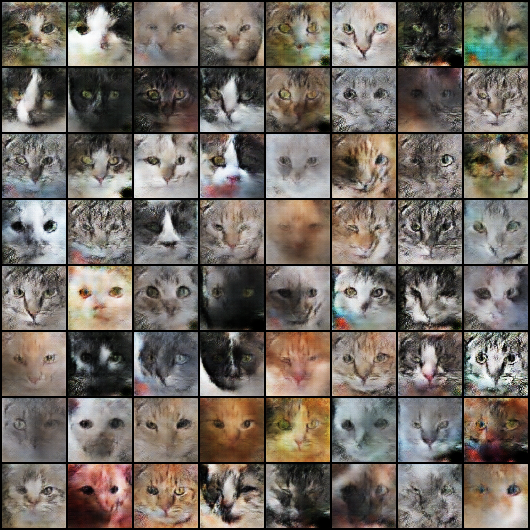

In [25]:
Image('./generated/generated-images-0060.png')

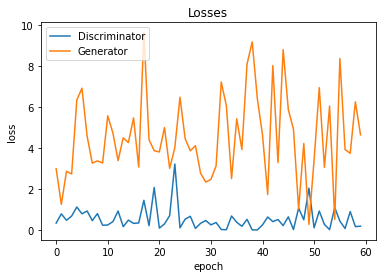

In [26]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

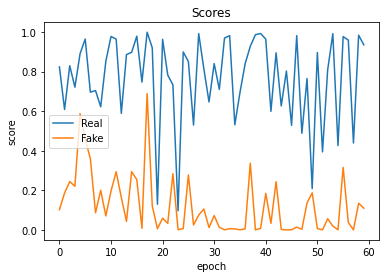

In [27]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');